<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.RwandaCO2Emissions/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/8.CO2Emissions/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Data preparation

## Download the data

In [17]:
df_train = pd.read_csv(f'{manager.data_trial_path}/train_processed.csv', index_col=0)
df_val = pd.read_csv(f'{manager.data_trial_path}/val_processed.csv', index_col=0)
df_test = pd.read_csv(f'{manager.data_trial_path}/test_processed.csv', index_col=0)
df_submission = pd.read_csv(f'{manager.data_trial_path}/submission_processed.csv', index_col=0)

df_train.shape, df_submission.shape

((50634, 84), (24353, 83))

In [4]:
df_train_original = pd.read_csv(f'{manager.train_path}')

In [5]:
df_train_original.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.

## Sample the subset

In [6]:
SUBSET_SIZE = 0.05
RANDOM_STATE = 42


df_subset, _ = train_test_split(
    df_train,
    train_size=SUBSET_SIZE,
    random_state=RANDOM_STATE
)

print(df_subset.shape)

(2531, 84)


## Get X, Y arrays

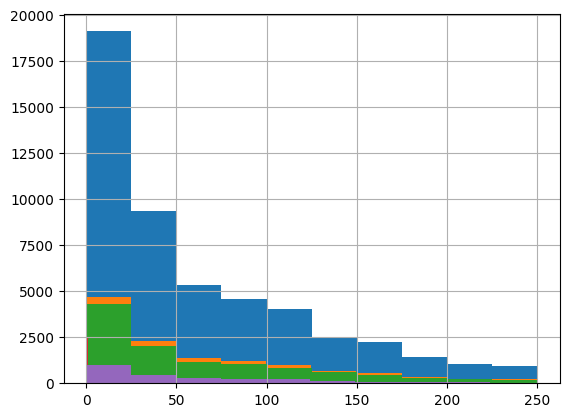

In [21]:
def X_Y(df, return_y=True):
    df.iloc[:, -1].hist()


    if return_y:
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
    else:
        X = df.iloc[:, :]
        y = None
    return X, y


X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)
X_test, Y_test = X_Y(df_test)
X_submission, _ = X_Y(df_submission, return_y=False)

X_subset, Y_subset = X_Y(df_subset)

# Find the baseline model

## K Neighbors regressor

### Grid search

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

grid = {
   'n_neighbors': [10, 50, 100],  # [1, 10, 100],
   'weights': ['distance'],
   'algorithm': ['auto'],
   'n_jobs': [-1]
}

knn_estimator = GridSearchCV(
    KNeighborsRegressor(),
    grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=4
)

In [ ]:
knn_res = knn_estimator.fit(
    X_train,
    Y_train
)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END algorithm=auto, n_jobs=-1, n_neighbors=10, weights=distance;, score=-2889.354 total time=   6.9s
[CV 2/3] END algorithm=auto, n_jobs=-1, n_neighbors=10, weights=distance;, score=-2893.489 total time=   5.2s
[CV 3/3] END algorithm=auto, n_jobs=-1, n_neighbors=10, weights=distance;, score=-2883.730 total time=   7.8s
[CV 1/3] END algorithm=auto, n_jobs=-1, n_neighbors=50, weights=distance;, score=-3057.390 total time=   5.4s
[CV 2/3] END algorithm=auto, n_jobs=-1, n_neighbors=50, weights=distance;, score=-3052.560 total time=   7.4s
[CV 3/3] END algorithm=auto, n_jobs=-1, n_neighbors=50, weights=distance;, score=-3053.361 total time=   6.0s
[CV 1/3] END algorithm=auto, n_jobs=-1, n_neighbors=100, weights=distance;, score=-3172.170 total time=   6.7s
[CV 2/3] END algorithm=auto, n_jobs=-1, n_neighbors=100, weights=distance;, score=-3166.944 total time=   8.9s
[CV 3/3] END algorithm=auto, n_jobs=-1, n_neighbors=100, we

In [ ]:
knn_res.cv_results_

{'mean_fit_time': array([0.0523773]),
 'std_fit_time': array([0.02193998]),
 'mean_score_time': array([7.50582846]),
 'std_score_time': array([1.81215108]),
 'param_n_neighbors': masked_array(data=[5],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5}],
 'split0_test_score': array([-3849.22534046]),
 'split1_test_score': array([-3875.42966489]),
 'split2_test_score': array([-3778.71986439]),
 'mean_test_score': array([-3834.45828991]),
 'std_test_score': array([40.83908026]),
 'rank_test_score': array([1], dtype=int32)}

In [ ]:
knn_res.best_score_

-2888.8576547937932

### Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

knn_random_search = RandomizedSearchCV(
    KNeighborsRegressor(),
    {
        'n_neighbors': np.arange(1, 50),
        'weights': ['uniform', 'distance'],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        # 'p': [0.5, 0.8, 1.0, 1.3, 1.6, 2.0, 3.0, 3.5, 4.0, 5.0, 10.0],
        'metric': ['minkowski'],
        'n_jobs': [-1]
    },
    cv=3,
    scoring='neg_mean_squared_error',
    random_state = RANDOM_STATE,
    return_train_score=False,
    verbose=4,
    n_iter=10,
    n_jobs=-1,
)

In [ ]:
knn_random_search.fit(
    X=X_train,
    y=Y_train
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: ignored

## Linear regressor

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

linear_regressor = RandomizedSearchCV(
    estimator=LinearRegression(),
    param_distributions={
        'n_jobs': [-1],
    },
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=RANDOM_STATE,
)

In [ ]:
from sklearn.preprocessing import StandardScaler

lin_reg_res = linear_regressor.fit(
    X=X_train,
    y=Y_train
)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
lin_reg_res.best_score_

-2364.1019702580634

## Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

ridge_estimator = RandomizedSearchCV(
    estimator=Ridge(),
    param_distributions={
        'alpha': np.linspace(0, 5, num=int((5-0)/0.02)),
        'random_state': np.arange(0, 100),
        'solver': ['auto']
    },
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=4,
    random_state=RANDOM_STATE
)

In [ ]:
ridge_reg_res = ridge_estimator.fit(
    X=X_train,
    y=Y_train
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END alpha=4.738955823293173, random_state=54, solver=auto;, score=-2382.444 total time=   0.1s
[CV 2/3] END alpha=4.738955823293173, random_state=54, solver=auto;, score=-2340.606 total time=   0.1s
[CV 3/3] END alpha=4.738955823293173, random_state=54, solver=auto;, score=-2370.562 total time=   0.1s
[CV 1/3] END alpha=3.1526104417670684, random_state=95, solver=auto;, score=-2382.110 total time=   0.1s
[CV 2/3] END alpha=3.1526104417670684, random_state=95, solver=auto;, score=-2340.389 total time=   0.1s
[CV 3/3] END alpha=3.1526104417670684, random_state=95, solver=auto;, score=-2370.259 total time=   0.1s
[CV 1/3] END alpha=0.1606425702811245, random_state=60, solver=auto;, score=-2381.760 total time=   0.1s
[CV 2/3] END alpha=0.1606425702811245, random_state=60, solver=auto;, score=-2340.299 total time=   0.0s
[CV 3/3] END alpha=0.1606425702811245, random_state=60, solver=auto;, score=-2370.136 total time=   0.

## Lasso regression

### Randomized CV search

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV

lasso_estimator = RandomizedSearchCV(
    estimator=Lasso(),
    param_distributions={
        'alpha': np.linspace(0, 100, num=int((100 - 0) / 0.5)),
        'fit_intercept': [True],
        'max_iter': [1000],
        'warm_start': [False, True],
    },
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=4,
    # n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=4,
    return_train_score=True
)

In [ ]:
lasso_res = lasso_estimator.fit(
    X_train,
    Y_train
)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END alpha=52.26130653266331, fit_intercept=True, max_iter=1000, warm_start=True;, score=(train=-3770.746, test=-3711.002) total time=   0.1s
[CV 2/4] END alpha=52.26130653266331, fit_intercept=True, max_iter=1000, warm_start=True;, score=(train=-3739.866, test=-3803.663) total time=   0.1s
[CV 3/4] END alpha=52.26130653266331, fit_intercept=True, max_iter=1000, warm_start=True;, score=(train=-3743.505, test=-3792.782) total time=   0.1s
[CV 4/4] END alpha=52.26130653266331, fit_intercept=True, max_iter=1000, warm_start=True;, score=(train=-3768.790, test=-3716.956) total time=   0.1s
[CV 1/4] END alpha=70.35175879396985, fit_intercept=True, max_iter=1000, warm_start=False;, score=(train=-3770.746, test=-3711.002) total time=   0.1s
[CV 2/4] END alpha=70.35175879396985, fit_intercept=True, max_iter=1000, warm_start=False;, score=(train=-3739.866, test=-3803.663) total time=   0.1s
[CV 3/4] END alpha=70.35175879396985,

In [ ]:
lasso_res.best_score_

-3316.940639071443

## Elastic Net regression

### Randomized CV search

In [ ]:
 np.linspace(0, 1, num=int(1 / 0.01))

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

elastic_net_estimator = RandomizedSearchCV(
    estimator=ElasticNet(),
    param_distributions={
        'alpha': np.arange(1, 10),
        'l1_ratio': np.linspace(0, 1, num=int((1 - 0) / 0.1)),
        'warm_start':  [True, False],
        'random_state': np.arange(1, 100),

    },
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    # n_jobs=-1,
    return_train_score=True,
    verbose=4
)

In [ ]:
elastic_net_res = elastic_net_estimator.fit(
    X_train,
    Y_train
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END alpha=9, l1_ratio=0.4444444444444444, random_state=17, warm_start=True;, score=(train=-3698.570, test=-3700.266) total time=   0.1s
[CV 2/3] END alpha=9, l1_ratio=0.4444444444444444, random_state=17, warm_start=True;, score=(train=-3705.016, test=-3690.027) total time=   0.1s
[CV 3/3] END alpha=9, l1_ratio=0.4444444444444444, random_state=17, warm_start=True;, score=(train=-3693.826, test=-3707.994) total time=   0.1s
[CV 1/3] END alpha=2, l1_ratio=0.5555555555555556, random_state=25, warm_start=False;, score=(train=-3496.660, test=-3498.912) total time=   0.1s
[CV 2/3] END alpha=2, l1_ratio=0.5555555555555556, random_state=25, warm_start=False;, score=(train=-3499.646, test=-3487.659) total time=   0.1s
[CV 3/3] END alpha=2, l1_ratio=0.5555555555555556, random_state=25, warm_start=False;, score=(train=-3491.191, test=-3508.855) total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.264e+07, tolerance: 1.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=9, l1_ratio=0.0, random_state=94, warm_start=True;, score=(train=-3673.084, test=-3673.289) total time=   6.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.271e+07, tolerance: 1.269e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=9, l1_ratio=0.0, random_state=94, warm_start=True;, score=(train=-3675.860, test=-3665.260) total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.256e+07, tolerance: 1.266e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=9, l1_ratio=0.0, random_state=94, warm_start=True;, score=(train=-3668.019, test=-3682.344) total time=   6.6s
[CV 1/3] END alpha=9, l1_ratio=0.5555555555555556, random_state=84, warm_start=True;, score=(train=-3700.677, test=-3702.542) total time=   0.1s
[CV 2/3] END alpha=9, l1_ratio=0.5555555555555556, random_state=84, warm_start=True;, score=(train=-3707.181, test=-3692.700) total time=   0.1s
[CV 3/3] END alpha=9, l1_ratio=0.5555555555555556, random_state=84, warm_start=True;, score=(train=-3695.765, test=-3709.339) total time=   0.0s
[CV 1/3] END alpha=8, l1_ratio=0.4444444444444444, random_state=35, warm_start=True;, score=(train=-3687.408, test=-3689.154) total time=   0.1s
[CV 2/3] END alpha=8, l1_ratio=0.4444444444444444, random_state=35, warm_start=True;, score=(train=-3694.041, test=-3678.784) total time=   0.1s
[CV 3/3] END alpha=8, l1_ratio=0.4444444444444444, random_state=35, warm_start=True;, score=(train=-3682.561, test=-3697.015) total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.246e+07, tolerance: 1.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=7, l1_ratio=0.0, random_state=6, warm_start=False;, score=(train=-3654.766, test=-3654.788) total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.252e+07, tolerance: 1.269e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=7, l1_ratio=0.0, random_state=6, warm_start=False;, score=(train=-3657.196, test=-3647.324) total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.238e+07, tolerance: 1.266e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=7, l1_ratio=0.0, random_state=6, warm_start=False;, score=(train=-3649.562, test=-3664.032) total time=   6.3s
[CV 1/3] END alpha=3, l1_ratio=0.8888888888888888, random_state=44, warm_start=True;, score=(train=-3513.095, test=-3517.724) total time=   0.1s
[CV 2/3] END alpha=3, l1_ratio=0.8888888888888888, random_state=44, warm_start=True;, score=(train=-3523.517, test=-3504.331) total time=   0.1s
[CV 3/3] END alpha=3, l1_ratio=0.8888888888888888, random_state=44, warm_start=True;, score=(train=-3507.712, test=-3526.099) total time=   0.1s
[CV 1/3] END alpha=5, l1_ratio=0.5555555555555556, random_state=21, warm_start=True;, score=(train=-3631.997, test=-3634.216) total time=   0.1s
[CV 2/3] END alpha=5, l1_ratio=0.5555555555555556, random_state=21, warm_start=True;, score=(train=-3639.747, test=-3623.374) total time=   0.1s
[CV 3/3] END alpha=5, l1_ratio=0.5555555555555556, random_state=21, warm_start=True;, score=(train=-3626.771, test=-3642.404) total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.101e+07, tolerance: 1.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=2, l1_ratio=0.0, random_state=74, warm_start=False;, score=(train=-3522.779, test=-3522.290) total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.105e+07, tolerance: 1.269e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=2, l1_ratio=0.0, random_state=74, warm_start=False;, score=(train=-3524.772, test=-3518.406) total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.092e+07, tolerance: 1.266e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=2, l1_ratio=0.0, random_state=74, warm_start=False;, score=(train=-3517.085, test=-3532.918) total time=   6.0s
[CV 1/3] END alpha=2, l1_ratio=0.2222222222222222, random_state=1, warm_start=True;, score=(train=-3516.252, test=-3516.502) total time=   0.1s
[CV 2/3] END alpha=2, l1_ratio=0.2222222222222222, random_state=1, warm_start=True;, score=(train=-3518.461, test=-3510.168) total time=   0.1s
[CV 3/3] END alpha=2, l1_ratio=0.2222222222222222, random_state=1, warm_start=True;, score=(train=-3510.881, test=-3526.965) total time=   0.1s
[CV 1/3] END alpha=1, l1_ratio=0.2222222222222222, random_state=58, warm_start=True;, score=(train=-3414.084, test=-3415.322) total time=   0.1s
[CV 2/3] END alpha=1, l1_ratio=0.2222222222222222, random_state=58, warm_start=True;, score=(train=-3418.283, test=-3411.136) total time=   0.1s
[CV 3/3] END alpha=1, l1_ratio=0.2222222222222222, random_state=58, warm_start=True;, score=(train=-3409.021, test=-3426.477) total time=   0.1s
[C

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.159e+07, tolerance: 1.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 1/3] END alpha=3, l1_ratio=0.0, random_state=34, warm_start=False;, score=(train=-3572.110, test=-3571.620) total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.163e+07, tolerance: 1.269e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 2/3] END alpha=3, l1_ratio=0.0, random_state=34, warm_start=False;, score=(train=-3573.869, test=-3566.560) total time=   6.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.150e+07, tolerance: 1.266e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV 3/3] END alpha=3, l1_ratio=0.0, random_state=34, warm_start=False;, score=(train=-3566.502, test=-3581.737) total time=   7.8s
[CV 1/3] END alpha=5, l1_ratio=0.7777777777777777, random_state=63, warm_start=False;, score=(train=-3609.709, test=-3612.588) total time=   0.1s
[CV 2/3] END alpha=5, l1_ratio=0.7777777777777777, random_state=63, warm_start=False;, score=(train=-3618.495, test=-3602.527) total time=   0.1s
[CV 3/3] END alpha=5, l1_ratio=0.7777777777777777, random_state=63, warm_start=False;, score=(train=-3603.878, test=-3619.016) total time=   0.1s
[CV 1/3] END alpha=1, l1_ratio=0.5555555555555556, random_state=38, warm_start=True;, score=(train=-3377.091, test=-3379.646) total time=   0.1s
[CV 2/3] END alpha=1, l1_ratio=0.5555555555555556, random_state=38, warm_start=True;, score=(train=-3382.628, test=-3372.705) total time=   0.1s
[CV 3/3] END alpha=1, l1_ratio=0.5555555555555556, random_state=38, warm_start=True;, score=(train=-3372.579, test=-3391.033) total time=   0

## Random forest regressor

### Model retrain

In [47]:
estimator = RandomForestRegressor(
    n_estimators=50,
    verbose=5,
    n_jobs=-1
)

estimator.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   37.3s


building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


RandomForestRegressor(n_estimators=50, n_jobs=-1, verbose=5)

In [50]:
from sklearn.metrics import mean_squared_error

print(
    mean_squared_error(
        estimator.predict(X_val),
        Y_val,
        squared=False
    )
)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.2s


13.210605420763219


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.9s finished


In [43]:
preds = estimator.predict(X_submission)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    2.3s finished


### Grid search CV

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


grid = {
    'n_estimators': [300]
}

res = GridSearchCV(
    RandomForestRegressor(),
    grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    refit=True,
    cv=3,
    verbose=4,
    return_train_score=True
)

In [38]:
cv_results = res.fit(
    X=X_train,
    y=Y_train,
)

KeyboardInterrupt: ignored

### Randomized search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

random_forest_reg = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions={
        'n_estimators': [50, 100, 300, 500, 700, 900, 1300, 1500],
        'max_depth': [*np.arange(1, 20), None],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        # 'min_samples_split': []
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'n_jobs': [-1],
        'random_state': np.arange(1000),
        'warm_start': [True],
    },
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=4
)

In [ ]:
random_forest_res = random_forest_reg_res = random_forest_reg.fit(
    X_subset.iloc[:1000, :],
    Y_subset[:1000],
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: ignored

## CatBoost

In [8]:
%%capture
!pip install catboost

### Randomized search

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

cat_boost_estimator = RandomizedSearchCV(
    CatBoostRegressor(),
    {
        'n_estimators': [i for i in range(100, 1000)],
        'depth': [i for i in range(2, 15)],
        'random_state': [i for i in range(100)],
        'reg_lambda': [0.001, 0.0001, 0.01, 0.1, 0.00001, 0.0],
        'verbose': [True]
    },
    cv=3,
    scoring='neg_mean_squared_error',
    n_iter=3,
    # n_jobs=-1,
    verbose=4
    # return_train_score=True
)

In [ ]:
cat_boost_res = cat_boost_estimator.fit(
    X_subset, # X_train,
    Y_subset  # Y_train
)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	learn: 61.4820497	total: 184ms	remaining: 1m 15s
1:	learn: 60.8788539	total: 309ms	remaining: 1m 2s
2:	learn: 60.1632586	total: 442ms	remaining: 1m
3:	learn: 59.6327351	total: 588ms	remaining: 59.7s
4:	learn: 59.0047055	total: 724ms	remaining: 58.6s
5:	learn: 58.4542447	total: 851ms	remaining: 57.3s
6:	learn: 57.9775542	total: 976ms	remaining: 56.2s
7:	learn: 57.3763805	total: 1.1s	remaining: 55.3s
8:	learn: 56.9411816	total: 1.23s	remaining: 55s
9:	learn: 56.3357089	total: 1.36s	remaining: 54.6s
10:	learn: 55.6534994	total: 1.51s	remaining: 54.8s
11:	learn: 55.1133736	total: 1.64s	remaining: 54.3s
12:	learn: 54.7206164	total: 1.76s	remaining: 53.8s
13:	learn: 54.3162124	total: 1.88s	remaining: 53.1s
14:	learn: 53.8936841	total: 2.01s	remaining: 52.9s
15:	learn: 53.3641834	total: 2.14s	remaining: 52.7s
16:	learn: 52.8681762	total: 2.26s	remaining: 52.3s
17:	learn: 52.4808944	total: 2.39s	remaining: 52.1s
18:	learn: 52.115565

KeyboardInterrupt: ignored

## SVM regression

### Randomized search

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

svr_estimator = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions={
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [1, 2, 3, 4, 5],
        'gamma': ['scale', 'auto'],
        'C': [0.01, 0.1, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, *np.arange(3, 10)],
    },
    cv=3,
    scoring='neg_mean_squared_error',
    n_iter=10,
    # n_jobs=-1,
    verbose=4
)

In [ ]:
svr_results = svr_estimator.fit(
    X_train,
    Y_train
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
svr_results.best_score_

## FFNN

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
model = Sequential(
    [
        Dense(500, activation='relu'),
        Dense(500, activation='relu'),
        Dense(300, activation='relu'),
        Dense(300, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ]
)

In [11]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
)

In [12]:
history = model.fit(
    x=X_train,  # df_train.iloc[:, :-1],
    y=Y_train,  # df_train['target'],
    epochs=100,
    # validation_split=0.2,
    validation_data=(X_val, Y_val),
    batch_size=32,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3
        )
    ]
)

Epoch 1/100
1583/1583 [==============================] - 23s 13ms/step - loss: 2609.8271 - val_loss: 2377.9033
Epoch 2/100
1583/1583 [==============================] - 19s 12ms/step - loss: 2323.0801 - val_loss: 2288.1582
Epoch 3/100
1583/1583 [==============================] - 27s 17ms/step - loss: 2214.2534 - val_loss: 2217.4180
Epoch 4/100
1583/1583 [==============================] - 27s 17ms/step - loss: 2118.1887 - val_loss: 2159.0789
Epoch 5/100
1583/1583 [==============================] - 19s 12ms/step - loss: 2049.1335 - val_loss: 2102.0115
Epoch 6/100
1583/1583 [==============================] - 21s 13ms/step - loss: 1981.7373 - val_loss: 2098.7178
Epoch 7/100
1583/1583 [==============================] - 27s 17ms/step - loss: 1932.5800 - val_loss: 2147.0981
Epoch 8/100
1583/1583 [==============================] - 21s 14ms/step - loss: 1866.0078 - val_loss: 2157.5498
Epoch 9/100
1583/1583 [==============================] - 22s 14ms/step - loss: 1812.6433 - val_loss: 2051.7510
E

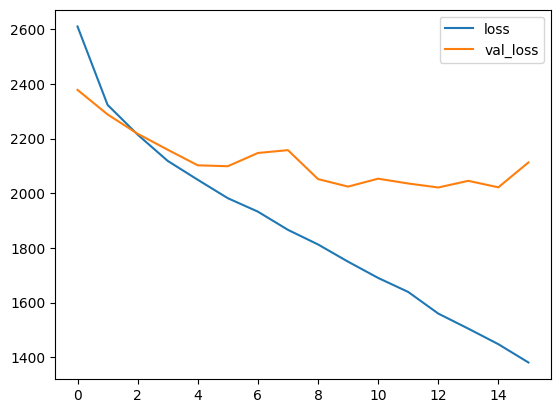

In [34]:
_, ax = plt.subplots()
ax.plot(
    history.history['loss'],
    label='loss'
)

ax.plot(
    history.history['val_loss'],
    label='val_loss'
)

ax.legend()

# Submit the predictions for FFNN

In [23]:
predictions = model.predict(X_submission)

762/762 [==============================] - 3s 3ms/step


In [44]:
df_submission_original = pd.read_csv(f'{manager.data_root_path}/sample_submission.csv')
df_submission_original['emission'] = preds # predictions
df_submission_original.to_csv(f'{manager.data_trial_path}/submission.csv', index=None)